In [19]:
import numpy as np
import geopandas as gpd
from scipy.stats import invgamma, norm,gamma
import matplotlib.pyplot as plt

municipal_gamma_df = gpd.read_file("C:\\Users\\pengyu\\Desktop\\correlation\\project-amazon\\data\\calibration\\hmc\\gamma_reg_site_1043.geojson")

X = municipal_gamma_df.iloc[:, 0:6].values  # Columns 1 to 6 as X
Y = municipal_gamma_df.iloc[:, 6].values    # Column 7 as Y
site_ids = municipal_gamma_df.iloc[:, 7].values -1   # Column 8 as site_ids

np.random.seed(45)
# beta_prior_mean = (6.245,0.019,-0.066,1.188,-0.05,1.11)

In [20]:


def gibbs_sampling_with_data(X, Y, site_ids, n_iterations=1000000, beta_prior_mean=None, beta_prior_cov=None, 
                             eta_prior_shape=2, eta_prior_scale=1, nu_prior_shape=2, nu_prior_scale=1):
    n_data, n_features = X.shape
    n_sites = len(np.unique(site_ids))
    
    # Initialize priors
    if beta_prior_mean is None:
        beta_prior_mean = np.zeros(n_features)
    if beta_prior_cov is None:
        beta_prior_cov = np.eye(n_features)   # Large prior variance
    
    # Initialize Gibbs sampling arrays
    beta_samples = np.zeros((n_iterations, n_features))
    eta_samples = np.zeros(n_iterations)
    nu_samples = np.zeros(n_iterations)
    V_samples = np.zeros((n_iterations, n_sites))
    
    # Initial values based on prior
    beta_current = np.random.multivariate_normal(beta_prior_mean, beta_prior_cov)
    eta_current = gamma.rvs(a=eta_prior_shape, scale=1/eta_prior_scale)
    nu_current = gamma.rvs(a=nu_prior_shape, scale=1/nu_prior_scale)
    V_current = np.zeros(n_sites)+0.01
    
    # Gibbs sampler
    for i in range(n_iterations):
        # Step i: Draw beta conditioned on V, eta, and data
        precision_beta = eta_current * (X.T @ X)
        mean_beta = np.linalg.inv(precision_beta) @ ( eta_current * X.T @ (Y - V_current[site_ids]))
        beta_current = np.random.multivariate_normal(mean_beta, np.linalg.inv(precision_beta))
        beta_samples[i, :] = beta_current
        
        # Step ii: Draw eta conditioned on V and data
        residuals = Y - X @ beta_current - V_current[site_ids]
        eta_shape_post =    n_data / 2
        eta_scale_post =  0.5 * np.sum(residuals**2)
        eta_current = gamma.rvs(a=eta_shape_post, scale=1/eta_scale_post)
        eta_samples[i] = eta_current
        
        # Step iii: Draw nu conditioned on V
        nu_shape_post =  n_sites / 2
        nu_scale_post =  0.5 * np.sum(V_current**2)
        nu_current = gamma.rvs(a=nu_shape_post, scale=1/nu_scale_post)
        nu_samples[i] = nu_current
        
        # nu_current = 1e10
        # nu_samples[i] = nu_current
        
        # Step iv: Draw V_j conditioned on beta, nu, eta, and data
        for j in range(n_sites):
            site_mask = site_ids == j
            n_j = np.sum(site_mask)
            V_bar_j = np.mean(Y[site_mask] - X[site_mask] @ beta_current)
            mean_V_j = (n_j * eta_current * V_bar_j) / (n_j * eta_current + nu_current)
            precision_V_j = n_j * eta_current + nu_current
            V_current[j] = np.random.normal(mean_V_j, np.sqrt(1 / precision_V_j))
        V_samples[i, :] = V_current
    
    
    beta_samples_final = beta_samples[50000:,:]
    eta_samples_final = eta_samples[50000:]
    nu_samples_final = nu_samples[50000:]
    V_samples_final = V_samples[50000:,:]
    
    # Posterior means
    beta_posterior_mean = beta_samples_final.mean(axis=0)
    eta_posterior_mean = eta_samples_final.mean()
    nu_posterior_mean = nu_samples_final.mean()
    
    return beta_posterior_mean, eta_posterior_mean, nu_posterior_mean, beta_samples_final, eta_samples_final, nu_samples_final, V_samples_final

# Run Gibbs sampling with the extracted data
# Assuming X, Y, and site_ids are already defined
beta_posterior_mean, eta_posterior_mean, nu_posterior_mean, beta_samples, eta_samples, nu_samples, V_samples = gibbs_sampling_with_data(X, Y, site_ids)

# Output the results
print(f"Posterior mean of beta: {beta_posterior_mean}")
print(f"Posterior mean of eta: {eta_posterior_mean}")
print(f"Posterior mean of nu: {nu_posterior_mean}")


Posterior mean of beta: [ 6.24163195e+00  1.63821764e-03 -7.29384547e-02  1.36128788e+00
 -1.04196006e-02  1.27059213e+00]
Posterior mean of eta: 68.08447250815307
Posterior mean of nu: 23.23557576857545


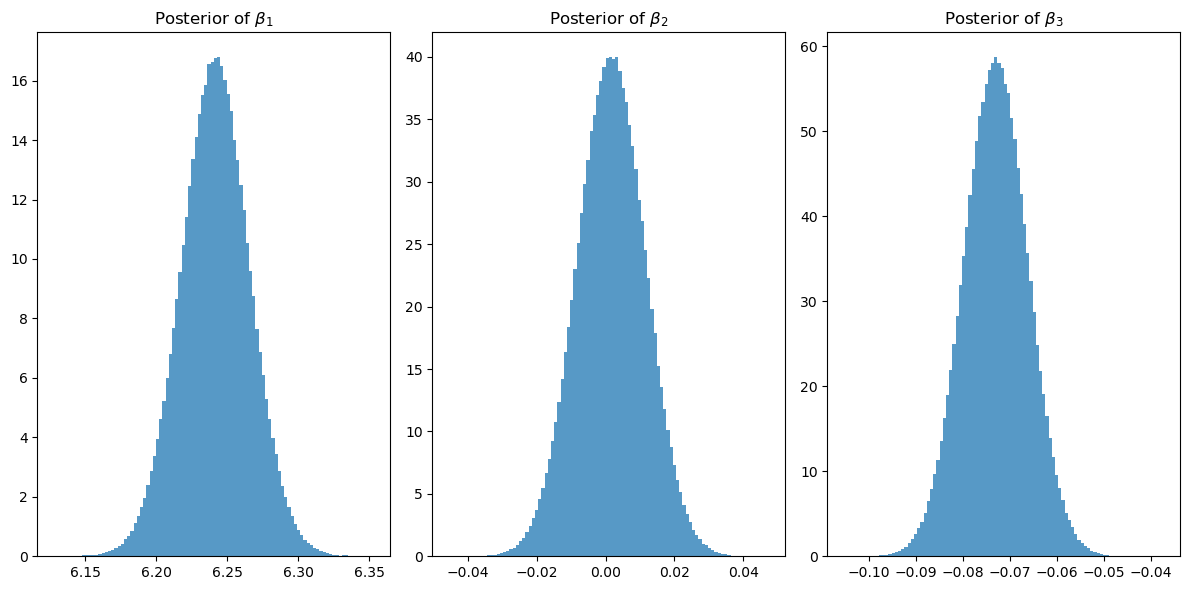

In [21]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(beta_samples[:, 0], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_1$')
plt.subplot(1, 3, 2)
plt.hist(beta_samples[:, 1], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_2$')
plt.subplot(1, 3, 3)
plt.hist(beta_samples[:, 2], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_3$')
plt.tight_layout()
plt.show()

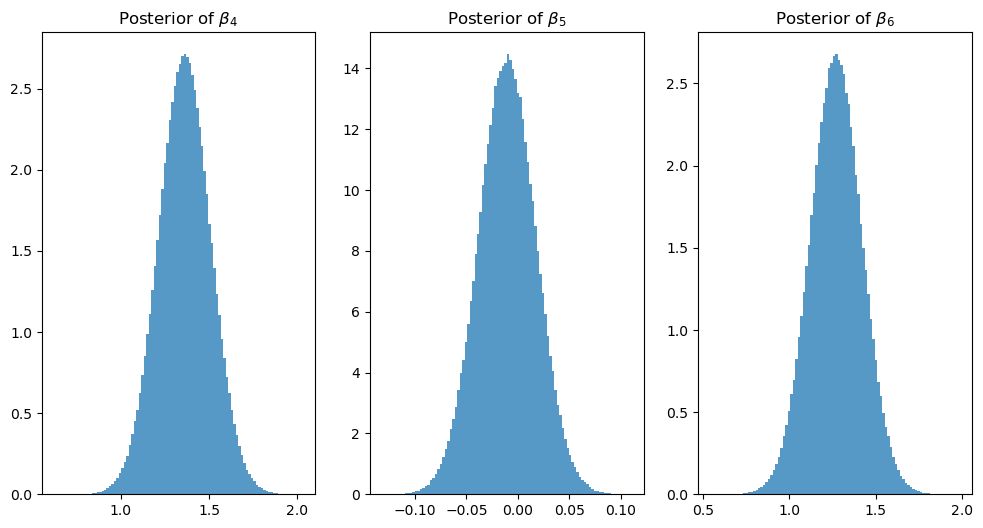

In [22]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.hist(beta_samples[:, 3], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_4$')
plt.subplot(1, 3, 2)
plt.hist(beta_samples[:, 4], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_5$')
plt.subplot(1, 3, 3)
plt.hist(beta_samples[:, 5], bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\beta_6$')
plt.show()

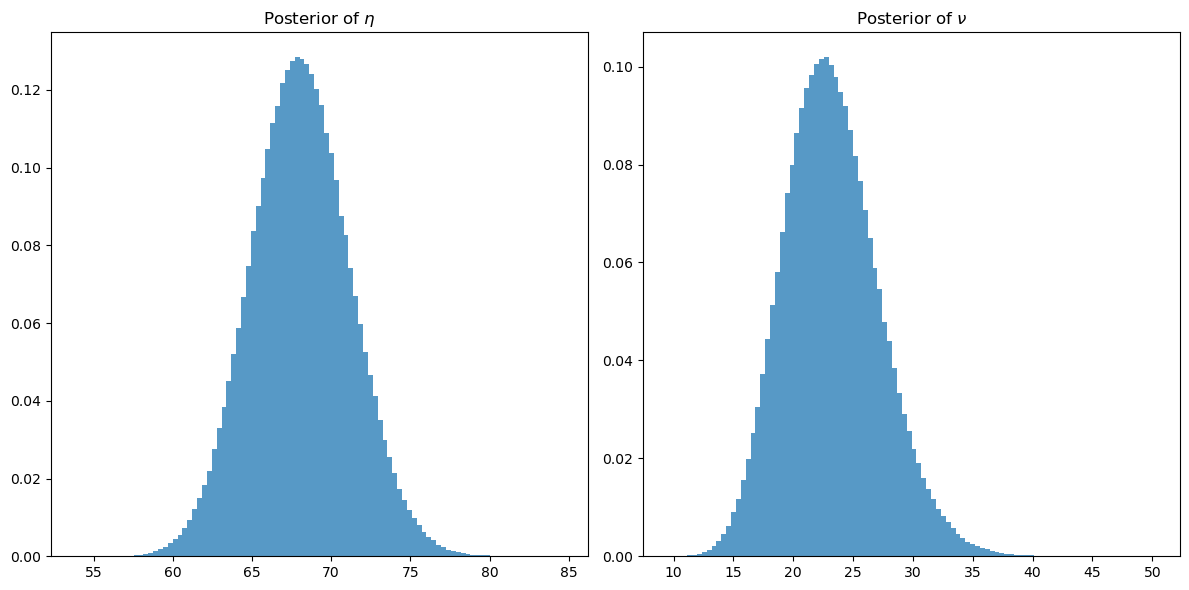

In [32]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(eta_samples, bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\eta$')
plt.subplot(1, 2, 2)
plt.hist(nu_samples, bins=100, density=True, alpha=0.75)
plt.title(r'Posterior of $\nu$')
plt.tight_layout()
plt.savefig("beta7")
plt.show()

In [24]:
import pandas as pd


df=pd.read_csv("gamma.csv").to_numpy()[:,]

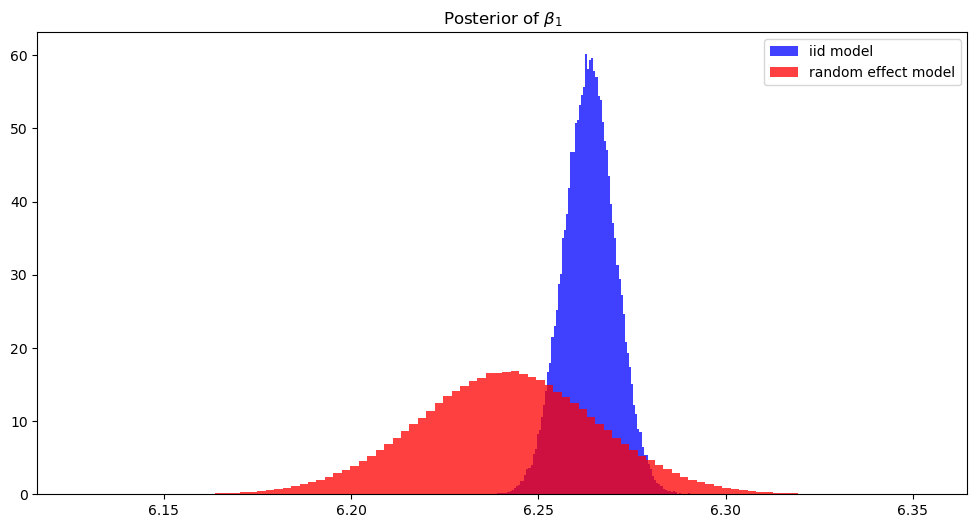

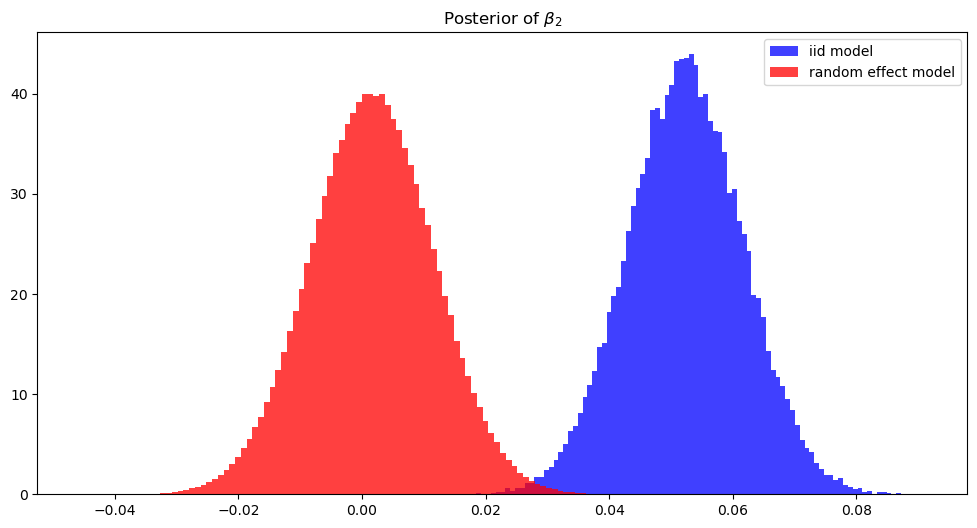

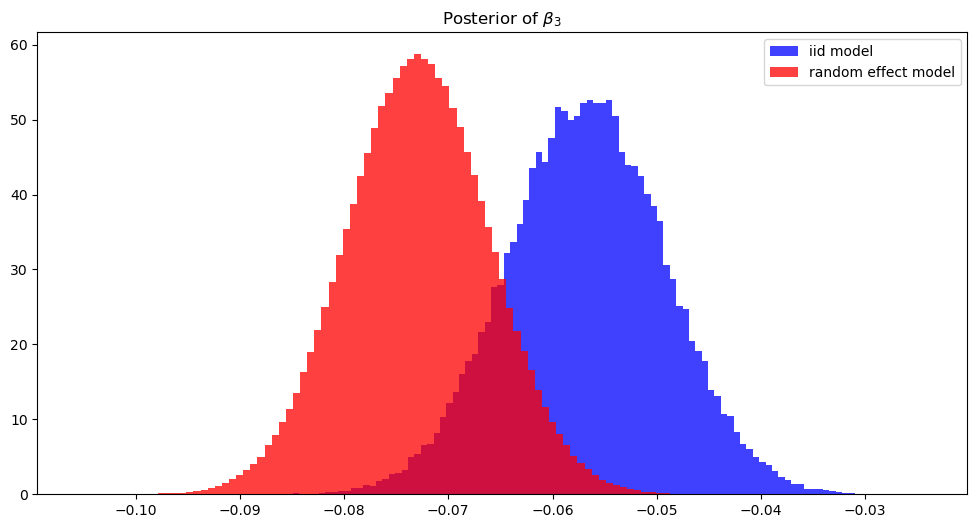

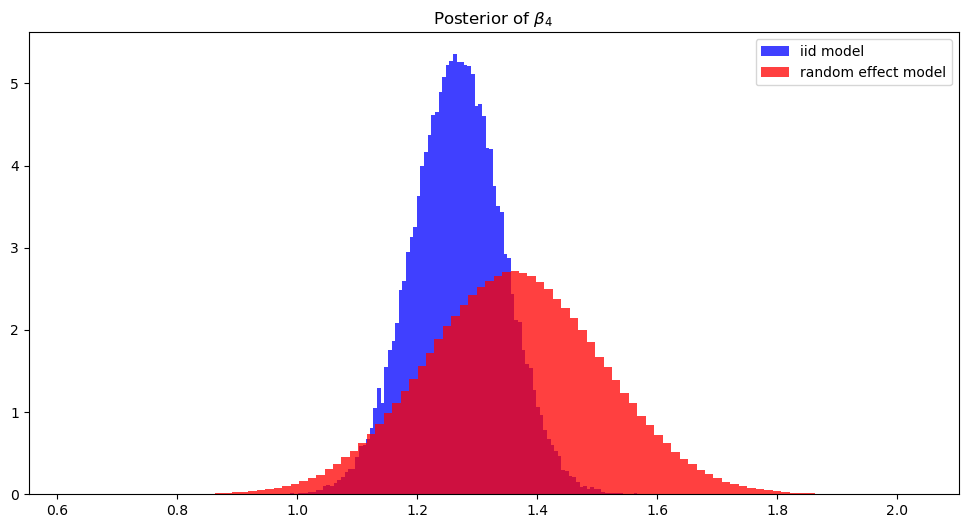

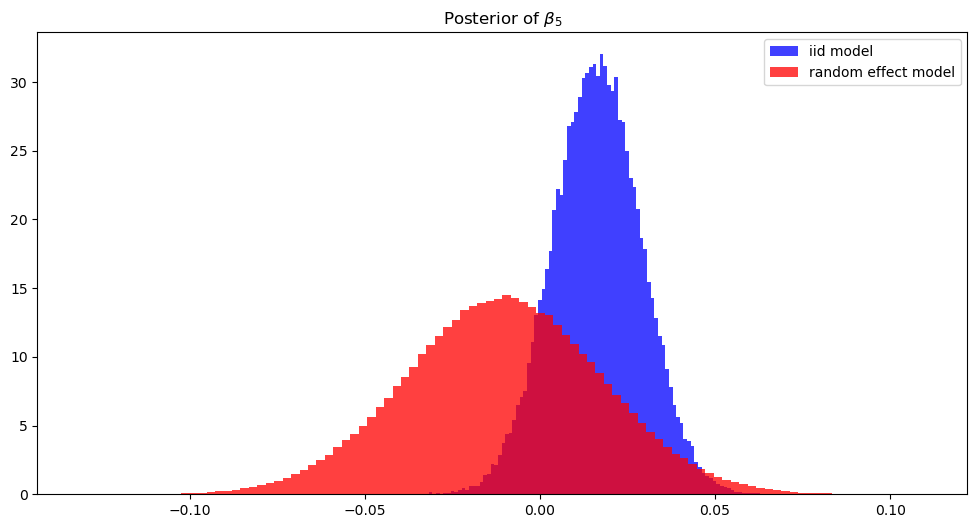

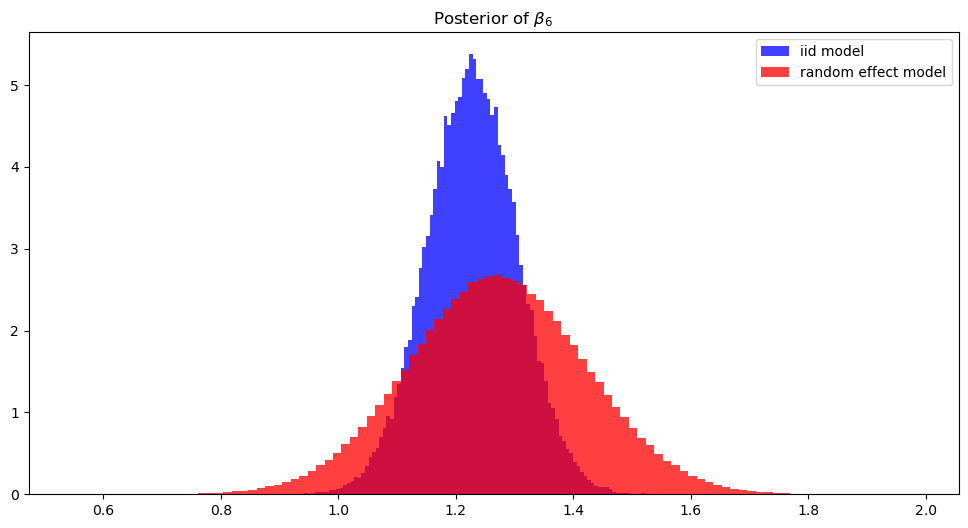

In [25]:
# Plotting the results

for i in range(6):
    plt.figure(figsize=(12, 6))
    plt.hist(df[:, i], bins=100, density=True, alpha=0.75,color = 'blue',label = 'iid model')
    plt.hist(beta_samples[:, i], bins=100, density=True, alpha=0.75, color = 'red', label = 'random effect model')
    plt.title(r'Posterior of $\beta_'+str(i+1)+'$')
    plt.legend()
    plt.savefig('beta'+str(i+1)+'.png')
    plt.show()



In [26]:
np.exp((X @ beta_samples.mean(axis=0)).mean())

513.7358054243093

In [27]:
np.exp((X @ df.mean(axis=0)).mean())

525.1984714303404